# Images with Minimal Background

**Scott Prahl**

**Mar 2021**

This notebook shows an analysis of a group of beam images with minimal background but with centers that wander about the frame.  In only a few of the beam locations does the integration rectangle extend slightly beyond the collected image.  The ISO 11146 algorithm works nicely for all these samples.

---
*If* `` laserbeamsize `` *is not installed, uncomment the following cell (i.e., delete the initial #) and execute it with *`` shift-enter ``*.  Afterwards, you may need to restart the kernel before the module will import successfully.*

In [1]:
#!pip install --user laserbeamsize

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

try:
    import laserbeamsize as lbs

except ModuleNotFoundError:
    print('laserbeamsize is not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')
    
pixel_size_µm = 3.75          # pixel size in microns for the camera
repo = "https://github.com/scottprahl/laserbeamsize/raw/master/docs/"

## Closely centered beam

Bright center, low background.  Beam is roughly 1/10 of the entire image.  Could not be easier.  

This is a Helium-Neon laser beam that is operating close to the TEM$_{00}$ mode.

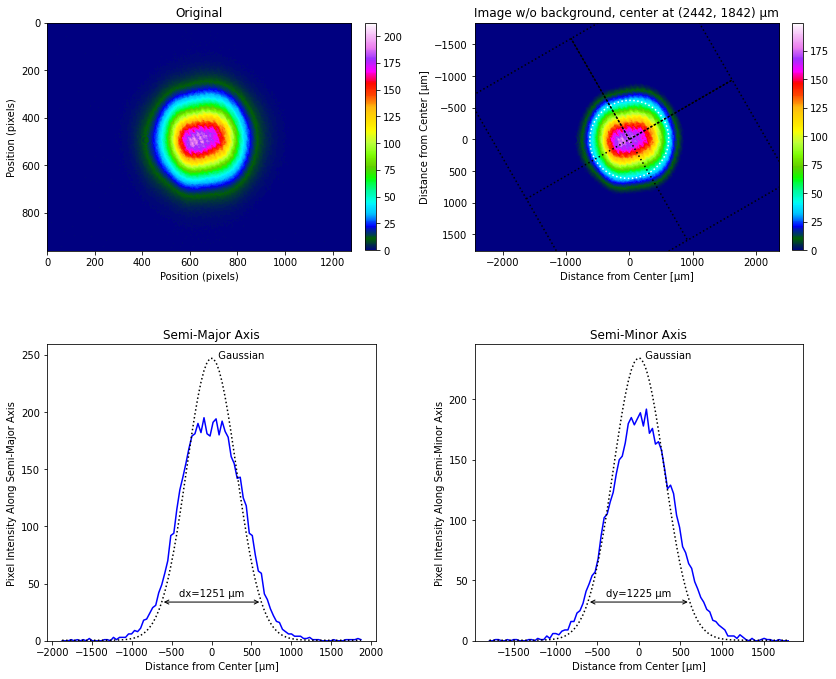

In [3]:
beam = imageio.imread(repo + "t-hene.pgm")
lbs.beam_size_plot(beam, pixel_size = pixel_size_µm, units='µm')
plt.show()

Further analysis of this beam image can be found in the Jupyter notebook on the [razor blade technique](05-Razor-Blade.html)

## Twelve different images near focus

This shows how the default ISO 11146 algorithm works with a good set of images.  

These are reasonably centered noise-free images measured near the focus of a beam.  

In [4]:
# array of distances at which images were collected
zz = np.array([168,210,280,348,414,480,495,510,520,580,666,770], dtype=float) * 1e-3 #m

# read them all into memory 
images = [imageio.imread(repo + "t-%dmm.pgm" % (z*1000)) for z in zz]

A basic analysis shows that all the beam centers are found without problem.

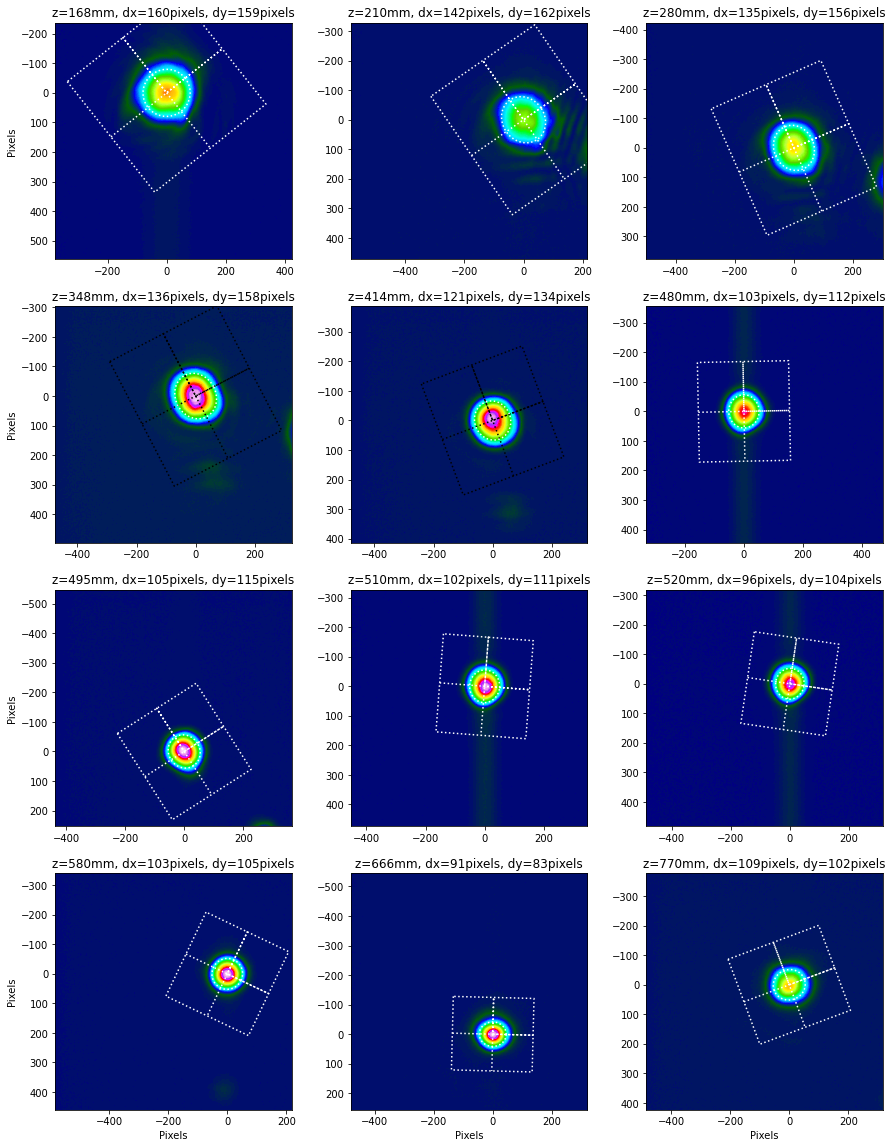

In [5]:
dx,dy=lbs.beam_size_montage(images, z=zz)

Zoom in on all the beams and display in with dimensions.

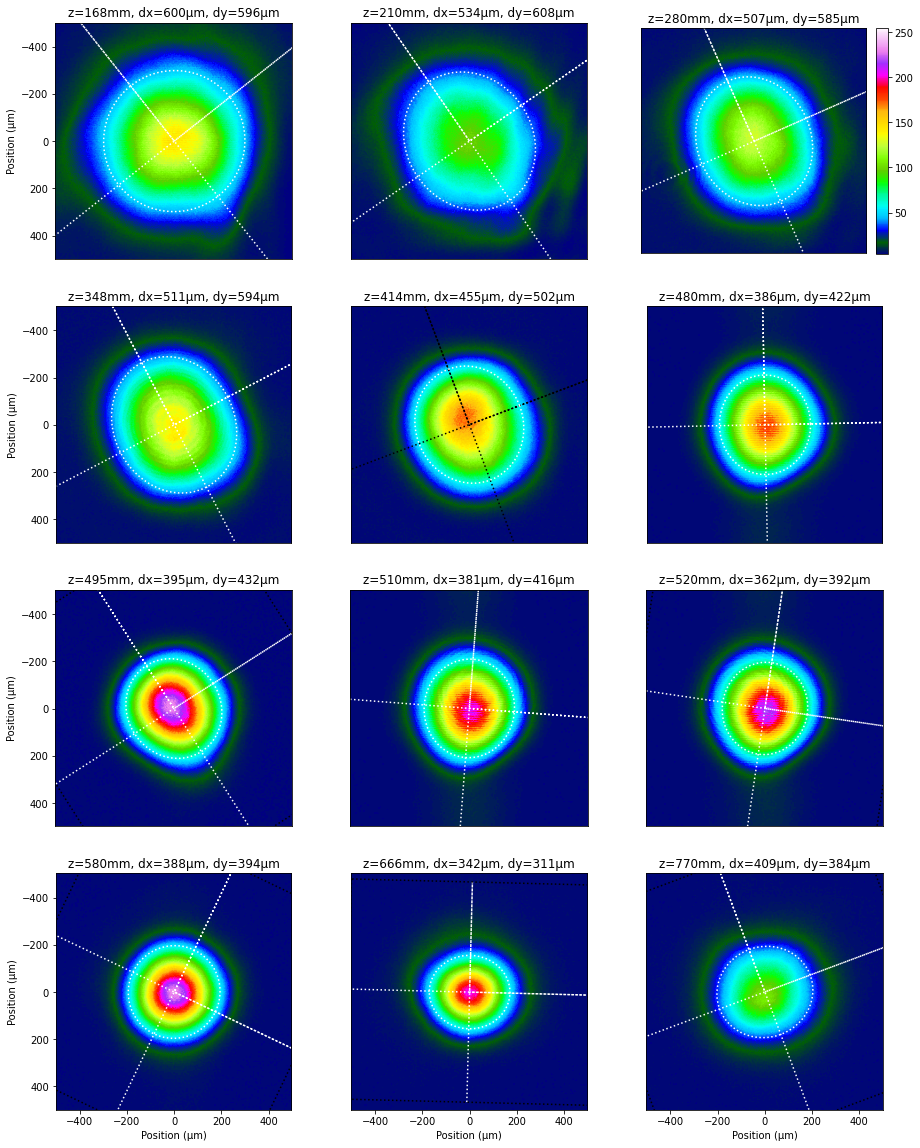

In [6]:
options = {'z':zz,                      # beam_size_montage assumes z locations in meters
           'pixel_size':pixel_size_µm,  # convert pixels to microns
           'units': 'µm',               # define units
           'vmax':255,                  # use same colorbar 0-255 for all images 
           'crop':[1000,1000],          # crop to 2x2mm area around beam center
          }

dx,dy=lbs.beam_size_montage(images, **options)

The algorithm locates each beam and produces plausible beam diameters.  When the dotted rectangle is not entirely enclosed in the image (as in the first two images) then the diameters are suspect.  I talk more about this in the M² notebooks.

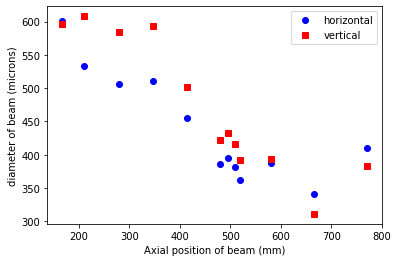

In [7]:
plt.plot(zz*1000,dx,'ob',label='horizontal')
plt.plot(zz*1000,dy,'sr',label='vertical')
plt.legend()
plt.xlabel('Axial position of beam (mm)')
plt.ylabel('diameter of beam (microns)')
plt.show()